# Projeto 2 - Ciência dos Dados - 2020.2 

### Previsão da demanda em lojas Walmart estadunidenses a fim de evitar o desperdício, maximizando o lucro nesses estabelecimentos

#### Equipe: Andressa Silva de Oliveira; Camila Buzin Ladeira; Luiz Ricardo Hardman; Matheus Kwon

## - Introdução -

### Objetivo:

A habilidade de prever dados de forma exata é extremamente valiosa em uma vasta gama de domínios como saúde, vendas, finanças, clima ou esportes (GIL, 2019). No contexto em questão, a previsão das vendas em lojas Walmart é uma técnica de gestão fundamental, a qual garante a qualidade da produção e evita perdas com estoque, logística e compras, além de servir como base para a tomada de decisões estratégicas. Dessa forma, é fundamental que tais previsões apresentem um alto nível de acurácia, uma vez que interferem diretamente nos resultados obtidos pela empresa, que se baseia nesses valores para estabelecer metas de vendas e definir uma logística funcional (BONOTTO, 2015). 

Objetiva-se, então, desenvolver ao longo deste documento a análise exploratória de uma base de dados acerca das vendas semanais em lojas Walmart estadunidenses, a construção de modelos preditivos baseados em técnicas de regressão e a posterior validação e comparação dos resultados obtidos. Dessa forma, espera-se chegar a um modelo que se adeque melhor à base de dados utilizada, sendo capaz de prever de forma mais precisa as demandas nesses estabelecimentos e contribuindo, então, para a otimização dos processos e maximização dos lucros. 


### Descrição da base de dados:

A base de dados (dataset) utilizada foi obtida por meio da plataforma Kaggle, a qual disponibiliza datasets variados para uso em competições e projetos científicos, e apresenta dados semanais relativos a 45 lojas Walmart estadunidenses ao longo de um período de três anos (entre 2010 e 2012). As variáveis presentes no dataset de interesse, descritas a seguir, são: store, data, weeklysales, holiday, temperature, fuel, cpi e unemployment.

**Variáveis da base de dados Walmart_Store_sales:**

- **store**: representa a numeração da loja representada, 1-45;
- **data**: variável que apresenta dia, mês e ano do dado, respectivamente, representando a semana em que as observações foram tomadas;
- **weeklysales** : variável que apresenta a receita de cada loja semanalmente (US\$) (variável de monitoramento);
- **holiday**: variável que representa se a data do dado é feriado ou não (yes/no);
- **temperature** : variável que apresenta a temperatura média da semana na região de  cada loja, em fahrenheit (°F);
- **fuel**: preço do galão de gasolina no dia do dado (US\$);
- **cpi** : variável que representa o preço médio necessário para comprar um conjunto de bens de consumo e serviços num país no dia, comparando com períodos anteriores ( Índice de preços no consumidor )  (US\$);
- **unemployment** : variável que representa a taxa de desemprego durante a semana, na região de cada loja, de zero a um.

Ao longo da análise em questão, serão considerados como **Target** (variável resposta ou dependente), os dados correspondentes à coluna weeklysales, uma vez que objetiva-se prever valores para essa variável quantitativa; e como **Features** (variáveis explicativas ou independentes), os dados correspondentes às demais colunas da base de dados.

Na primeira célula de código, que se encontra abaixo, colocou-se, para fins de organização, os comandos utilizados para importar todas as bibliotecas que foram utilizadas ao longo do desenvolvimento do documento em questão. Cada linha do código importa uma biblioteca distinta, a qual possibilita o uso de diferentes comandos de manipulação e análise de dados.

In [100]:
# Bibliotecas importadas:

import os
import random
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

import statsmodels.api as sm
import seaborn as sns

from sklearn.metrics import mean_squared_error

# Imports para o segundo modelo
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score, GridSearchCV

## - Minerando Dados e Características do Dataset -

### Mineração:

A primeira etapa, denominada mineração, corresponde à coleta dos dados e, uma vez que todas as informações que serão utilizadas já se encontram no dataset supracitado, tendo-se já adicionado este ao repositório, utilizou-se o código abaixo a fim de garantir que o dataset está sendo reconhecido.

In [101]:
# Código para reconhecimento do dataset:
filename = 'Walmart_Store_sales.xlsx'

if filename in os.listdir():
    print(f'Encontrei o arquivo {filename}, tudo certo!')
else:
    print(f'Não encontrei o arquivo {filename} no diretório {os.getcwd()}')

Encontrei o arquivo Walmart_Store_sales.xlsx, tudo certo!


Em seguida, armazenando a base de dados na variável “data”, plotou-se as cinco primeiras linhas, verificando-se então, o formato do dataset, no qual todos os dados estão em apenas uma coluna e separados por vírgula.

In [102]:
# Código para leitura do dataset:
data = pd.read_excel(filename)
data.head(5)

,"Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment"
0,"1,05-02-2010,1643690.9,0,42.31,2.572,211.09635..."
1,"1,12-02-2010,1641957.44,1,38.51,2.548,211.2421..."
2,"1,19-02-2010,1611968.17,0,39.93,2.514,211.2891..."
3,"1,26-02-2010,1409727.59,0,46.63,2.561,211.3196..."
4,"1,05-03-2010,1554806.68,0,46.5,2.625,211.35014..."


### Análise descritiva detalhada:

Posteriormente, iniciou-se a etapa de limpeza e análise descritiva a fim de compreender as características e relações entre as variáveis do dataset. Para isso, no código abaixo separou-se a coluna única em forma de listas, as quais foram adicionadas como valores em um dicionário cujas chaves são os nomes de cada variável presente no dataset. 

In [103]:
# Manipulação do dataset para fins do projeto

linhas = data['Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment']

dicio = {'store':[], 'date':[], 'weeklysales':[], 'holiday':[], 'temperature':[], 'fuel':[], 'cpi':[], 'unemployment':[]}

# Separação das colunas no dicionário, em forma de listas

for linha in linhas:
    results = linha.split(',')
    i = 0
    for key in dicio.keys():
        variable = results[i]
        if key != 'date' and key != 'store':
            variable = float(results[i])
        dicio[key].append(variable)
        i += 1


Esse dicionário foi, então, transformado em um DataFrame, formato que possibilita o uso de comandos da biblioteca Pandas (criada e amplamente utilizada para análise e manipulação de dados diversos) e facilita a visualização dos dados. Além disso, algumas das suas variáveis foram manipuladas como comentado no código abaixo e, em seguida, plotou-se novamente as primeiras cinco linhas, verificando-se que a manipulação para organização do dataset funcionou como esperado, uma vez que cada variável de interesse passou a se localizar em uma coluna diferente.

In [104]:
# Transformando o dicionário em dataframe:

df = pd.DataFrame()
for key, lista in dicio.items():
    df[key] = pd.Series(lista)
    
# Transformando as variáveis de acordo com o seu tipo:

df.holiday = df.holiday.astype('int') # define a variável holiday como número inteiro
df.store = df.store.astype('category') # define o número da loja como variável qualitativa ordinal
df.date = pd.to_datetime(df.date) # define a variável para datas
df.unemployment = (df.unemployment)/100 # taxa de desemprego(em porcentagem)/100
df.head(5)

,store,date,weeklysales,holiday,temperature,fuel,cpi,unemployment
0,1,2010-05-02,1643690.90,0,42.31,2.572,211.096358,0.08106
1,1,2010-12-02,1641957.44,1,38.51,2.548,211.242170,0.08106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,0.08106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,0.08106
4,1,2010-05-03,1554806.68,0,46.50,2.625,211.350143,0.08106


* #### Análise descritiva detalhada das variáveis weeklysales, temperature, fuel, cpi, unemployment e store:

Após a criação do DataFrame e separação das variáveis em colunas distintas, iniciou-se a análise detalhada das variáveis a fim de compreender o comportamento dessas ao longo do período a que os dados referem-se. Para isso, armazenou-se na variável "df_analise1" as colunas: weeklysales, temperature, fuel, cpi e unemployment do DataFrame e, utilizando-se o comando ".describe()" obteve-se as medidas resumo de tais colunas, como pode ser visto a seguir:

In [105]:
# Análise das variáveis quantitativas

df_analise1 = df[['weeklysales','temperature','fuel','cpi','unemployment']]
df_analise1.describe()

,weeklysales,temperature,fuel,cpi,unemployment
count,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000
mean,1.046965e+06,60.663782,3.358607,171.578394,0.079992
std,5.643666e+05,18.444933,0.459020,39.356712,0.018759
min,2.099862e+05,-2.060000,2.472000,126.064000,0.038790
25%,5.533501e+05,47.460000,2.933000,131.735000,0.068910
50%,9.607460e+05,62.670000,3.445000,182.616521,0.078740
75%,1.420159e+06,74.940000,3.735000,212.743293,0.086220
max,3.818686e+06,100.140000,4.468000,227.232807,0.143130


A obtenção dos parâmetros acima permite a análise de características como a média (mean) de cada variável quantitativa, a qual ilustra o comportamento médio de cada variável levando em conta os dados de todas as lojas ao longo do período analisado, o desvio padrão (std), o qual indica o grau de variação entre os dados considerados, alguns quantis notáveis, que indicam até cada porcentagem (25%, 50% e 75%) de dados de cada coluna, em ordem crescente, o valor máximo alcançado por eles, bem como seus valores mínimos e máximos, possibilitando uma análise inicial dos valores como um todo.

Posteriormente, verificou-se se as colunas apresentavam valores indefinidos, os quais geralmente aparecem como "Nan" e podem representar algum erro. Para tal, utilizou-se o código abaixo, o qual percorre as colunas selecionadas anteriormente e devolve a contagem de valores indefinidos e, como pode ser visto a seguir, nenhum valor desse tipo foi encontrado.

In [106]:
# Verificando se há valores indefinidos

df_analise1.isnull().sum()

weeklysales     0
temperature     0
fuel            0
cpi             0
unemployment    0
dtype: int64

Em seguida, a fim de verificar de maneira mais global como a variável de monitoramento (weeklysales) comporta-se ao longo de todo o período analisado, plotou-se um gráfico de dispersão das vendas semanais (eixo y) ao longo do tempo (eixo x), no qual cada dado correspondente a essa variável presente no DataFrame é representado como um ponto em azul, observando-se o comportamento ilustrado a seguir:

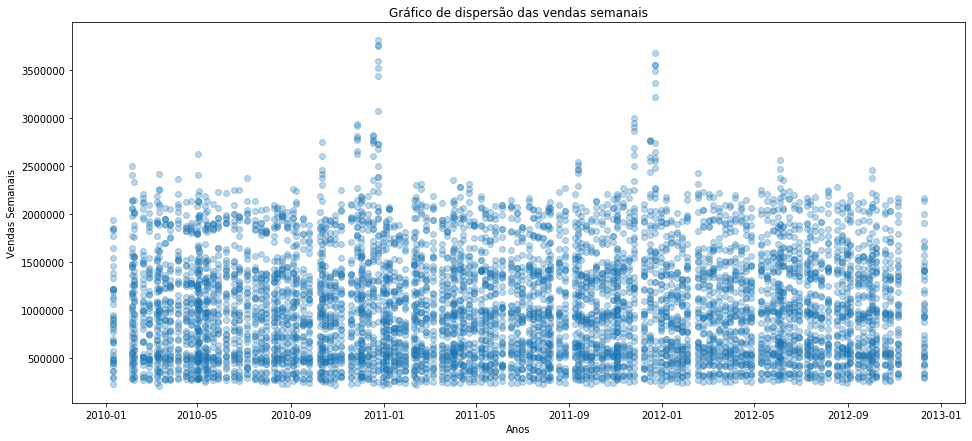

In [107]:
# Gráfico de dispersão das vendas semanais para todas as lojas ao longo do período 2010 a 2012

plt.figure(figsize=(16, 7))
plt.title('Gráfico de dispersão das vendas semanais')
plt.xlabel('Anos')
plt.ylabel('Vendas Semanais')
plt.plot(df.date, df.weeklysales, 'o', alpha=0.3)
plt.show()

* A partir do gráfico acima, percebe-se que nas semanas próximas ao fim de cada ano ocorre, em geral, um aumento nas vendas semanais

Posterioemente, visando analisar de maneira mais particular o comportamento da variável de monitoramento e de cada loja, plotou-se os três gráficos de dispersão ilustrados abaixo. Para isso, utilizou-se a lógica ilustrada na primeira parte do código que segue a fim de permitir que a escolha da loja e do ano a serem plotados seja aleatória, e, em seguida, o código para plotar e configurar os gráficos assim como feito na célula anterior.

Store 27, year 2012


TypeError: float() argument must be a string or a number, not 'Timestamp'

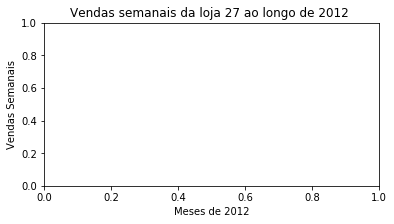

In [108]:
# Gráfico de dispersão das vendas semanais para lojas selecionadas aleatoriamente durante um ano selecionado
# também aleatoriamente

teste_lojas = []
teste_anos = []
for x in range(3):
    
    a = True # loop para não repetir loja e ano
    while a == True:
        n = random.randint(1,45)
        year = random.randint(2010,2012)
        if n not in teste_lojas and year not in teste_anos:
            teste_lojas.append(n)
            teste_anos.append(year)
            a = False
    
    filtroano = []
    for i in df.date:
        if i.year == year:
            filtroano.append(True)
        else:
            filtroano.append(False)
    
    filtrostore = df.store == str(n)
    
    datesano = []
    for i in range(len(df)):
        if df.date[i].year == year and df.store[i] == str(n):
            datesano.append(df.date[i])
    
    salesyear = df.loc[filtroano & filtrostore,'weeklysales']
    
    print(f'Store {n}, year {year}')
    plt.figure(figsize=(6, 3))
    plt.title('Vendas semanais da loja {0} ao longo de {1} '.format(n,year))
    plt.ylabel('Vendas Semanais')
    plt.xlabel('Meses de {0}'.format(year))
    plt.plot(datesano, salesyear,'o', alpha=0.5)
    plt.show()

* Assim como observado no comportamento de todas as lojas juntas, ilustrado no gráfico anterior, percebe-se para cada loja que, em geral, há um aumento nas vendas semanais no período próximo ao final do ano.

* #### Análise descritiva detalhada das variáveis weeklysale e holiday:

Após a análise das variáveis anteriores, iniciou-se a de holiday, que fornece ao dia a característica de ser feriado ou não, o que é indicado pelos valores inteiros 1 ou 0, respectivamente. Para isso, inicialmente utilizou-se o comando abaixo para selecionar, no DataFrame, as linhas de dias que eram feriado, nomeadas como "yes" e as de dias que não o eram, nomeadas como "no", e posteriormente selecionar apenas a coluna weeklysales para cada um desses rótulos com o uso do comando ".loc[]". Após essa seleção, plotou-se as medidas resumo para a variável weeklysales em cada situação, observando-se os resultados abaixo:

In [109]:
# Análise da relação entre as variáveis weeklysales e holiday

no = df.holiday == 0
yes = df.holiday == 1

holiday_no = df.loc[no,["weeklysales"]]
holiday_yes = df.loc[yes,["weeklysales"]]

medidas_resumo_holiday_no = holiday_no.describe()
medidas_resumo_holiday_yes = holiday_yes.describe()

In [110]:
# Medidas resumo para semanas sem feriado

medidas_resumo_holiday_no.round(3)

,weeklysales
count,5985.000
mean,1041256.380
std,558957.436
min,209986.250
25%,551378.390
50%,956211.200
75%,1414343.530
max,3818686.450


In [111]:
# Medidas resumo para semanas com feriado

medidas_resumo_holiday_yes.round(3)

,weeklysales
count,450.000
mean,1122887.892
std,627684.932
min,215359.210
25%,575865.482
50%,1018538.040
75%,1555213.175
max,3004702.330


* Analisando-se as medidas resumo obtidas acima, percebe-se que, quando há feriado, a média das vendas semanais é maior. No entanto, nessas mesmas semanas observa-se também uma variância maior, o que significa que há lojas com vendas bem maiores que outras e também que há feriados em que as vendas são maiores do que em outros.

Plotou-se também os histogramas a seguir a fim de visualizar os valores descritos acima:

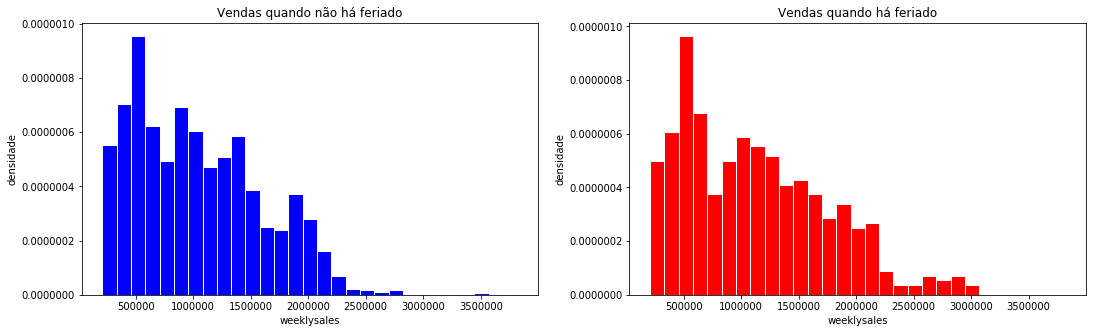

In [112]:
# Análise, em histograma, das vendas semanais para semanas em que não há ou não feriado

faixas = np.linspace(df.weeklysales.min(),df.weeklysales.max(),30)

plt.figure(figsize=(18, 5))

plt.subplot(121)
plt.hist(holiday_no.weeklysales, bins=faixas, density=True, color='blue', edgecolor='white')
plt.ylabel('densidade')
plt.xlabel('weeklysales')
plt.title('Vendas quando não há feriado')

plt.subplot(122)
plt.hist(holiday_yes.weeklysales, bins=faixas, density=True, color='red', edgecolor='white')
plt.ylabel('densidade')
plt.xlabel('weeklysales')
plt.title('Vendas quando há feriado')

plt.show()

* #### Análise geral das relações entre weeklysales e as demais variáveis

Tendo-se realizado as analises detalhadas acima, plotou-se os gráficos a seguir a fim de relacionar o target às demais features, obtendo-se os comportamentos ilustrados a seguir:

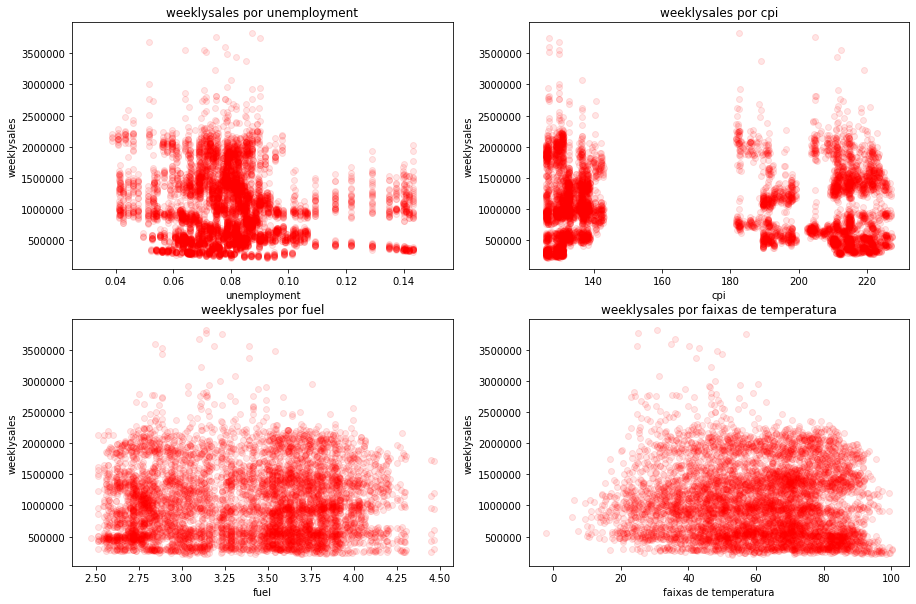

In [113]:
fig = plt.figure(figsize=(15,10))

# weeklysales com unemployment
plt.subplot(221)
plt.scatter(df.unemployment, df.weeklysales, c='red', alpha=0.1)
plt.title('weeklysales por unemployment')
plt.ylabel('weeklysales')
plt.xlabel('unemployment')

# weeklysales com cpi
plt.subplot(222)
plt.scatter(df.cpi, df.weeklysales, c='red', alpha=0.1)
plt.title('weeklysales por cpi')
plt.ylabel('weeklysales')
plt.xlabel('cpi')

# weeklysales com fuel
plt.subplot(223)
plt.scatter(df.fuel, df.weeklysales, c='red', alpha=0.1)
plt.title('weeklysales por fuel')
plt.ylabel('weeklysales')
plt.xlabel('fuel')

# weeklysales com temperature
plt.subplot(224)
plt.scatter(df.temperature, df.weeklysales, c='red', alpha=0.1)
plt.title('weeklysales por faixas de temperatura')
plt.ylabel('weeklysales')
plt.xlabel('faixas de temperatura')

plt.show()

A análise desses gráficos não permite nenhuma conclusão específica, uma vez que mesmo os dados estando agrupados não há um comportamento típico de crescimento ou descrescimento que levem à conclusão de que há uma relação positiva ou negativa, respectivamente. Dessa forma, a fim de verificar se os formatos acima permitem a percepção de alguma relação não visível apenas graficamente utilizou-se os comandos abaixo para plotar os valores de correlação, que indicam pelo seu sinal se as realações entre as variáveis são positivas ou negativas; e pelo seu valor, se são fortes ou fracas.

In [114]:
# Correlações referentes às variáveis ilustradas nos gráficos acima

nomes = ['unemployment','cpi', 'fuel', 'temperature','holiday']
dfs = [df.unemployment, df.cpi, df.fuel, df.temperature, df.holiday]
for i in range(len(nomes)):
    print('Correlação entre {0} e weeklysales é: {1}'.format(nomes[i], df.weeklysales.corr(dfs[i])))

Correlação entre unemployment e weeklysales é: -0.10617608965795428
Correlação entre cpi e weeklysales é: -0.07263416204017631
Correlação entre fuel e weeklysales é: 0.009463786314475123
Correlação entre temperature e weeklysales é: -0.0638100131794696
Correlação entre holiday e weeklysales é: 0.03689096801041456


* As correlações mostram, então, uma baixa relação entre as features ilustradas e o target, uma vez que os valores obtidos são pequenos. Sendo assim, fez-se também uma análise de múltiplas features de forma conjunta utilizando-se o comando abaixo, o qual permite relacionar weeklysales a todas as demais variáveis de uma vez.

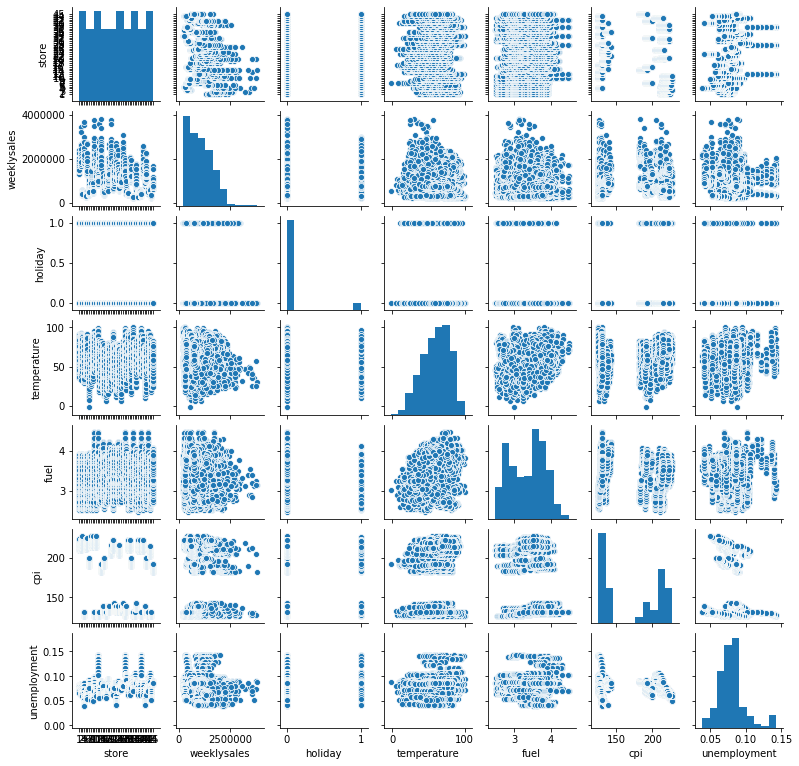

In [115]:
# Pairplot com as combinações de todas as variáveis quantitativas envolvidas

sns.pairplot(df, height=1.5);

* Percebe-se novamente, a partir dos gráficos acima, que não há nenhuma relação clara entre as variáveis, o que condiz com as análises feitas anteriormente.

## - Modelos de Predição -

* ### Separação da base de dados em conjuntos de treinamento e teste:

Após observar o comportamento da variável target em função das features, percebeu-se que há baixa correlação entre cada feature individualmente e as vendas semanais. Por isso, como primeiro modelo de inferência da variável de interesse, foi escolhida a regressão linear múltipla, na qual considera-se mais de uma feature para a previsão da target - função linear para cada feature.

Além disso, é razoável também monitorar as vendas semanais para cada mês do ano para diferentes anos. Então, foram adicionadas as features mês e ano de cada dado como novas colunas do DataFrame.


In [116]:
x = df.date.dt.year
df['year'] = pd.Series(x)
y = df.date.dt.month
df['month'] = pd.Series(y)
df

df.year = df.year.astype('int')
df.month = df.month.astype('int')

Verificou-se abaixo os tipos de variáveis da base de dados:

In [117]:
df.dtypes

store                 category
date            datetime64[ns]
weeklysales            float64
holiday                  int32
temperature            float64
fuel                   float64
cpi                    float64
unemployment           float64
year                     int32
month                    int32
dtype: object

Embaralhou-se, então, todos os dados e foram selecionados os primeiros 75% para o treinamento e o restante foi deixado para teste:


In [118]:
df_shuffle = df.sample(frac = 1) 
df_treinamento = df_shuffle.head(int(len(df)*(0.75)+1))
df_teste = df_shuffle.tail(int(len(df)*(0.25)))

Posteriormente, observou-se se os dois conjuntos estão com as devidas quantidades de dados:

In [119]:
df_treinamento

,store,date,weeklysales,holiday,temperature,fuel,cpi,unemployment,year,month
2826,20,2012-09-03,2139265.40,0,41.14,3.848,213.871114,0.06961,2012,9
92,1,2011-11-11,1594938.89,0,59.11,3.297,217.998085,0.07866,2011,11
197,2,2011-02-18,2080884.82,0,57.83,3.045,212.903312,0.08028,2011,2
4685,33,2012-09-03,287346.29,0,62.20,3.963,130.741379,0.07603,2012,9
1445,11,2010-05-21,1271646.62,0,76.97,2.826,213.911689,0.07343,2010,5
...,...,...,...,...,...,...,...,...,...,...
2705,19,2012-10-08,1408907.89,0,74.45,3.863,138.143774,0.08193,2012,10
979,7,2012-01-06,598495.02,0,55.06,3.764,197.621895,0.08090,2012,1
201,2,2011-03-18,1902557.66,0,62.32,3.488,214.015624,0.08028,2011,3
3190,23,2010-10-12,1872365.99,0,20.12,3.132,132.676400,0.05287,2010,10


In [120]:
df_teste

,store,date,weeklysales,holiday,temperature,fuel,cpi,unemployment,year,month
832,6,2012-04-05,1543461.12,0,77.66,3.749,223.280054,0.05964,2012,4
1879,14,2010-06-25,2246179.91,0,79.32,2.808,182.380600,0.08899,2010,6
3265,23,2012-05-18,1332952.47,0,58.42,3.899,138.106581,0.04125,2012,5
1350,10,2011-04-22,2004831.14,0,75.93,3.917,128.955300,0.08494,2011,4
2714,19,2012-12-10,1352809.50,0,48.29,4.186,138.911700,0.07992,2012,12
...,...,...,...,...,...,...,...,...,...,...
1667,12,2011-11-25,1591920.42,1,53.25,3.622,129.836400,0.12890,2011,11
3305,24,2010-05-28,1473868.15,0,69.59,3.046,132.293936,0.08211,2010,5
2052,15,2011-01-21,487311.03,0,21.84,3.391,133.028516,0.07771,2011,1
1409,10,2012-08-06,1840491.41,0,86.87,4.103,130.889677,0.07382,2012,8


### 1° modelo: Modelo de Regressão Linear Múltipla

* Hipóteses adotadas:

**$α = 0,1\%$**

**H0: não há relação entre weeklysales e a variável analisada - $β = 0$** $\Rightarrow$ probabilidades acima de $α$

**H1: há relação entre weeklysales e a variável analisada - $β ≠ 0$** $\Rightarrow$ probabilidades abaixo de $α$

Para iniciar o modelo de regressão linear múltipla, utilizou-se como features as variáveis quantitativas de temperatura (temperature), de preço da gasolina (fuel), de índice de preços no consumidor (cpi) e de taxa de desemprego (unemployment) e as variáveis qualitativas de feriado (holiday), de ano (year) e de mês (month), que foram quantificadas em números para o modelo, além da variável target de vendas semanais (weeklysales).

In [121]:
# Regressão linear múltipla para a combinação weeklysales com holiday, temperature, fuel, cpi, unemployment, year e
# month; todas as variáveis quantitativas.

x = df_treinamento[['holiday','temperature','fuel','cpi','unemployment', 'year', 'month']]
y = df_treinamento['weeklysales']

Então, pelo método dos mínimos quadrados do modelo de regressão OLS, da biblioteca statsmodels, verificou-se a probabilidade de cada feature estar realmente associada à variação de weeklysales.

In [122]:
xc = sm.add_constant(x)
model = sm.OLS(y,xc)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            weeklysales   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     19.79
Date:                Tue, 24 Nov 2020   Prob (F-statistic):           2.54e-26
Time:                        23:05:46   Log-Likelihood:                -70709.
No. Observations:                4827   AIC:                         1.414e+05
Df Residuals:                    4819   BIC:                         1.415e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.258e+08   3.62e+07      3.474      0.001    5.48e+07    1.97e+08
holiday       1.072e+04   3.44e+04      0.312      0.755   -5.66e+04    7.81e+04
temperature  -1032.6433    466.858     -2.212      0.027   -1947.898    -117.388
fuel          7.588e+04   3.11e+04      2.439      0.015    1.49e+04    1.37e+05
cpi          -1204.0225    235.641     -5.110      0.000   -1665.986    -742.059
unemployment -4.334e+06   4.78e+05     -9.066      0.000   -5.27e+06    -3.4e+06
year         -6.191e+04   1.81e+04     -3.429      0.001   -9.73e+04   -2.65e+04
month         9944.2357   2607.239      3.814      0.000    4832.857    1.51e+04
==============================================================================
Omnibus:                      272.186   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              320.028
Skew:                           0.630   Prob(JB):                     3.21e-70
Kurtosis:                       2.965   Cond. No.                     9.12e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.12e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

* A probabilidade de |t| de holiday é muito maior do que o alpha adotado, o que significa que a hipótese H0 não é rejeitada e conclui-se, então, que não há relação significativa para o modelo entre weeklysales e holiday e, portanto, pode-se desconsiderar holiday na análise.

In [123]:
# Regressão linear múltipla para a combinação weeklysales com temperature, fuel, cpi, unemployment, year e month

x = df_treinamento[['temperature','fuel','cpi','unemployment', 'year', 'month']]
y = df_treinamento['weeklysales']

xc = sm.add_constant(x)
model = sm.OLS(y,xc)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            weeklysales   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     23.08
Date:                Tue, 24 Nov 2020   Prob (F-statistic):           5.28e-27
Time:                        23:05:46   Log-Likelihood:                -70709.
No. Observations:                4827   AIC:                         1.414e+05
Df Residuals:                    4820   BIC:                         1.415e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.252e+08   3.62e+07      3.462      0.001    5.43e+07    1.96e+08
temperature  -1058.4670    459.426     -2.304      0.021   -1959.152    -157.782
fuel           7.53e+04   3.11e+04      2.425      0.015    1.44e+04    1.36e+05
cpi          -1203.0562    235.599     -5.106      0.000   -1664.937    -741.176
unemployment -4.327e+06   4.78e+05     -9.063      0.000   -5.26e+06   -3.39e+06
year          -6.16e+04    1.8e+04     -3.417      0.001   -9.69e+04   -2.63e+04
month         1.023e+04   2443.043      4.187      0.000    5438.802     1.5e+04
==============================================================================
Omnibus:                      272.452   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              320.385
Skew:                           0.631   Prob(JB):                     2.69e-70
Kurtosis:                       2.963   Cond. No.                     9.11e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.11e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

* A probabilidade de |t| de fuel é maior do que o alpha adotado, então, a variável também é desconsiderada da inferência.

In [124]:
# Regressão linear múltipla para a combinação weeklysales com temperature, cpi, unemployment, year e month

x = df_treinamento[['temperature', 'cpi','unemployment', 'year', 'month']]
y = df_treinamento['weeklysales']

xc = sm.add_constant(x)
model = sm.OLS(y,xc)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            weeklysales   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     26.49
Date:                Tue, 24 Nov 2020   Prob (F-statistic):           1.68e-26
Time:                        23:05:46   Log-Likelihood:                -70712.
No. Observations:                4827   AIC:                         1.414e+05
Df Residuals:                    4821   BIC:                         1.415e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         5.432e+07   2.13e+07      2.550      0.011    1.26e+07    9.61e+07
temperature   -822.1001    449.192     -1.830      0.067   -1702.722      58.522
cpi          -1411.7467    219.426     -6.434      0.000   -1841.922    -981.571
unemployment -4.189e+06   4.74e+05     -8.831      0.000   -5.12e+06   -3.26e+06
year         -2.622e+04   1.06e+04     -2.476      0.013    -4.7e+04   -5461.064
month         1.075e+04   2434.805      4.415      0.000    5976.004    1.55e+04
==============================================================================
Omnibus:                      273.029   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              321.214
Skew:                           0.632   Prob(JB):                     1.78e-70
Kurtosis:                       2.975   Cond. No.                     5.36e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.36e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

* A probabilidade de |t| de year é maior do que o alpha adotado, então, como H0 não é rejeitado, conclui-se que não há relação significativa para o modelo entre weeklysales e year, portanto year também é desconsiderado da inferência.

In [125]:
# Regressão linear múltipla para a combinação weeklysales com cpi e unemployment

x = df_treinamento[['temperature', 'cpi','unemployment', 'month']]
y = df_treinamento['weeklysales']

xc = sm.add_constant(x)
model = sm.OLS(y,xc)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            weeklysales   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     31.55
Date:                Tue, 24 Nov 2020   Prob (F-statistic):           5.56e-26
Time:                        23:05:46   Log-Likelihood:                -70715.
No. Observations:                4827   AIC:                         1.414e+05
Df Residuals:                    4822   BIC:                         1.415e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.574e+06   6.22e+04     25.304      0.000    1.45e+06     1.7e+06
temperature   -929.2199    447.343     -2.077      0.038   -1806.215     -52.225
cpi          -1399.1337    219.484     -6.375      0.000   -1829.422    -968.845
unemployment  -3.89e+06   4.59e+05     -8.476      0.000   -4.79e+06   -2.99e+06
month         1.162e+04   2410.723      4.819      0.000    6891.233    1.63e+04
==============================================================================
Omnibus:                      279.021   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              329.445
Skew:                           0.640   Prob(JB):                     2.90e-72
Kurtosis:                       2.996   Cond. No.                     1.07e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.07e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [126]:
# Regressão linear múltipla para a combinação weeklysales com cpi, unemployment e month

x = df_treinamento[['cpi','unemployment', 'month']]
y = df_treinamento['weeklysales']

xc = sm.add_constant(x)
model = sm.OLS(y,xc)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            weeklysales   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     40.60
Date:                Tue, 24 Nov 2020   Prob (F-statistic):           6.66e-26
Time:                        23:05:46   Log-Likelihood:                -70718.
No. Observations:                4827   AIC:                         1.414e+05
Df Residuals:                    4823   BIC:                         1.415e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          1.55e+06   6.12e+04     25.352      0.000    1.43e+06    1.67e+06
cpi          -1501.2504    213.981     -7.016      0.000   -1920.751   -1081.750
unemployment  -4.05e+06   4.53e+05     -8.948      0.000   -4.94e+06   -3.16e+06
month         1.132e+04   2407.186      4.701      0.000    6597.007     1.6e+04
==============================================================================
Omnibus:                      278.314   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              328.247
Skew:                           0.638   Prob(JB):                     5.27e-72
Kurtosis:                       3.044   Cond. No.                     1.00e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  1e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Pelos resultados obtidos por esse modelo, apenas as variáveis cpi, unemployment e month foram suficientes para descrever weeklysales. Então, resta apenas verificar algumas suposições do modelo de regressão linear: 

1) hipótese de que a distribuição dos resíduos - diferença entre os valores reais de vendas semanais e os previstos - segue uma distribuição normal;

2) hipótese de que há presença de homocedasticidade no modelo - os dados apresentam uma configuração típica com pontos não muito dispersos.

* #### Verificando as suposições do modelo de regressão linear:

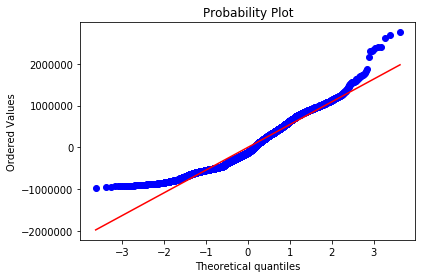

In [127]:
# Verificando a suposição de que os erros têm distribuição Normal

stats.probplot(results.resid, dist='norm', plot=plt);

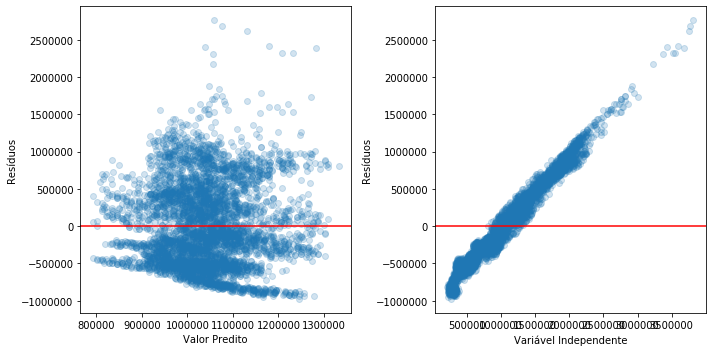

In [128]:
# Verificando a suposição de homocedasticidade:

fig = plt.figure(figsize = (10,5))

plt.subplot(121)
plt.scatter(results.predict(xc), results.resid, alpha=0.2);
plt.axhline(y = 0, color = 'r', linestyle = '-');
plt.ylabel('Resíduos')
plt.xlabel('Valor Predito')

plt.subplot(122)
plt.scatter(y, results.resid, alpha=0.2);
plt.axhline(y = 0, color = 'r', linestyle = '-'); # o valor da variável aleatórias está correto ?
plt.ylabel('Resíduos')
plt.xlabel('Variável Independente')

plt.tight_layout()
plt.show()

* Como evidenciado nos gráficos acima, as hipóteses do modelo não são seguidas. Dessa forma, a fim de tentar ajustá-las, utilizou-se a escala logarítmica como ilustrado abaixo:

In [129]:
# Retira valores abaixo de 0

filtrotemperature1 = df_treinamento.temperature > 0
df_treinamento_log = df_treinamento.loc[filtrotemperature1,:]

filtrotemperature2 = df_teste.temperature > 0
df_teste_log = df_teste.loc[filtrotemperature2,:]

In [130]:
# Alterando a escala para log

df_treinamento_log.weeklysales = np.log(df_treinamento_log.weeklysales)
df_treinamento_log.temperature = np.log(df_treinamento_log.temperature)
df_treinamento_log.fuel = np.log(df_treinamento_log.fuel)
df_treinamento_log.cpi = np.log(df_treinamento_log.cpi)
df_treinamento_log.unemployment = np.log(df_treinamento_log.unemployment*100)
df_treinamento_log.month = np.log(df_treinamento_log.month)
df_treinamento_log.year = np.log(df_treinamento_log.year)
df_treinamento_log

C:\Users\Andressa SO\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,store,date,weeklysales,holiday,temperature,fuel,cpi,unemployment,year,month
2826,20,2012-09-03,14.575973,0,3.716981,1.347554,5.365374,1.940323,7.606885,2.197225
92,1,2011-11-11,14.282346,0,4.079400,1.193013,5.384486,2.062550,7.606387,2.397895
197,2,2011-02-18,14.548304,0,4.057508,1.113501,5.360838,2.082935,7.606387,0.693147
4685,33,2012-09-03,12.568443,0,4.130355,1.377001,4.873221,2.028543,7.606885,2.197225
1445,11,2010-05-21,14.055823,0,4.343416,1.038862,5.365563,1.993747,7.605890,1.609438
...,...,...,...,...,...,...,...,...,...,...
2705,19,2012-10-08,14.158325,0,4.310128,1.351444,4.928295,2.103280,7.606885,2.302585
979,7,2012-01-06,13.302173,0,4.008423,1.325482,5.286356,2.090629,7.606885,0.000000
201,2,2011-03-18,14.458710,0,4.132282,1.249329,5.366049,2.082935,7.606387,1.098612
3190,23,2010-10-12,14.442713,0,3.001714,1.141672,4.887913,1.665251,7.605890,2.302585


In [131]:
df_teste_log.weeklysales = np.log(df_teste_log.weeklysales)
df_teste_log.temperature = np.log(df_teste_log.temperature)
df_teste_log.fuel = np.log(df_teste_log.fuel)
df_teste_log.cpi = np.log(df_teste_log.cpi)
df_teste_log.unemployment = np.log(df_teste_log.unemployment*100)
df_teste_log.month = np.log(df_teste_log.month)
df_teste_log.year = np.log(df_teste_log.year)
df_teste_log

,store,date,weeklysales,holiday,temperature,fuel,cpi,unemployment,year,month
832,6,2012-04-05,14.249538,0,4.352340,1.321489,5.408427,1.785741,7.606885,1.386294
1879,14,2010-06-25,14.624742,0,4.373490,1.032472,5.206096,2.185939,7.605890,1.791759
3265,23,2012-05-18,14.102907,0,4.067658,1.360720,4.928026,1.417066,7.606885,1.609438
1350,10,2011-04-22,14.511070,0,4.329812,1.365326,4.859466,2.139360,7.606387,1.386294
2714,19,2012-12-10,14.117694,0,3.877224,1.431746,4.933838,2.078441,7.606885,2.484907
...,...,...,...,...,...,...,...,...,...,...
1667,12,2011-11-25,14.280452,1,3.974998,1.287026,4.866275,2.556452,7.606387,2.397895
3305,24,2010-05-28,14.203401,0,4.242621,1.113829,4.885026,2.105475,7.605890,1.609438
2052,15,2011-01-21,13.096658,0,3.083743,1.221125,4.890564,2.050399,7.606387,0.000000
1409,10,2012-08-06,14.425543,0,4.464413,1.411718,4.874355,1.999045,7.606885,2.079442


In [132]:
df_analise2 = df_treinamento_log[['weeklysales','temperature','fuel','cpi','unemployment', 'year', 'month']]
df_analise2.describe()

,weeklysales,temperature,fuel,cpi,unemployment,year,month
count,4826.000000,4826.000000,4826.000000,4826.000000,4826.000000,4826.000000,4826.000000
mean,13.695293,4.046719,1.201195,5.120731,2.052865,7.606366,1.672311
std,0.590721,0.368272,0.139625,0.232455,0.222998,0.000395,0.691973
min,12.254797,1.711995,0.905028,4.836790,1.355577,7.605890,0.000000
25%,13.217095,3.863043,1.075429,4.882657,1.930361,7.605890,1.386294
50%,13.770346,4.137244,1.235181,5.211892,2.063312,7.606387,1.791759
75%,14.163120,4.316821,1.317480,5.360828,2.151181,7.606885,2.197225
max,15.155417,4.605870,1.496941,5.425975,2.661168,7.606885,2.484907


In [133]:
# Verificando se há valores indefinidos

df_analise2.isnull().sum()

weeklysales     0
temperature     0
fuel            0
cpi             0
unemployment    0
year            0
month           0
dtype: int64

Refez-se, então, o modelo a partir da variáveis em escala logarítmica, como ilustrado abaixo:

In [134]:
logx =  df_treinamento_log[['temperature','fuel','cpi','unemployment', 'month', 'year']]
logy = df_treinamento_log['weeklysales']

logxc = sm.add_constant(logx)
logmodel = sm.OLS(logy,logxc)
logresults = logmodel.fit()
logresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            weeklysales   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     16.33
Date:                Tue, 24 Nov 2020   Prob (F-statistic):           1.05e-18
Time:                        23:05:47   Log-Likelihood:                -4258.3
No. Observations:                4826   AIC:                             8531.
Df Residuals:                    4819   BIC:                             8576.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          881.4021    297.623      2.961      0.003     297.926    1464.878
temperature     -0.1027      0.024     -4.209      0.000      -0.151      -0.055
fuel             0.2882      0.110      2.630      0.009       0.073       0.503
cpi             -0.1525      0.041     -3.718      0.000      -0.233      -0.072
unemployment    -0.2708      0.041     -6.543      0.000      -0.352      -0.190
month            0.0377      0.013      2.987      0.003       0.013       0.062
year          -113.8998     39.146     -2.910      0.004    -190.643     -37.157
==============================================================================
Omnibus:                      447.332   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              199.953
Skew:                          -0.309   Prob(JB):                     3.81e-44
Kurtosis:                       2.218   Cond. No.                     3.74e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.74e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

* As variáveis fuel e year puderam ser descartadas de acordo com a mesma análise utlizada, anteriormente, para o modelo sem o uso de logarítmo.

In [135]:
logx =  df_treinamento_log[['temperature', 'cpi','unemployment', 'month']]
logy = df_treinamento_log['weeklysales']

logxc = sm.add_constant(logx)
logmodel = sm.OLS(logy,logxc)
logresults = logmodel.fit()
logresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            weeklysales   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     22.29
Date:                Tue, 24 Nov 2020   Prob (F-statistic):           2.91e-18
Time:                        23:05:47   Log-Likelihood:                -4262.6
No. Observations:                4826   AIC:                             8535.
Df Residuals:                    4821   BIC:                             8568.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           15.4756      0.230     67.414      0.000      15.026      15.926
temperature     -0.0939      0.024     -3.940      0.000      -0.141      -0.047
cpi             -0.1914      0.038     -5.016      0.000      -0.266      -0.117
unemployment    -0.2411      0.039     -6.119      0.000      -0.318      -0.164
month            0.0445      0.012      3.600      0.000       0.020       0.069
==============================================================================
Omnibus:                      436.421   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              197.132
Skew:                          -0.307   Prob(JB):                     1.56e-43
Kurtosis:                       2.224   Cond. No.                         197.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* #### Verificando as suposições do modelo de regressão linear em escala logarítmica:

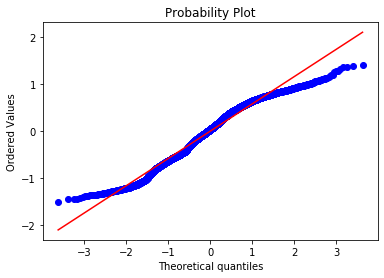

In [136]:
# Verificando a suposição de que os erros têm distribuição Normal

stats.probplot(logresults.resid, dist='norm', plot=plt);

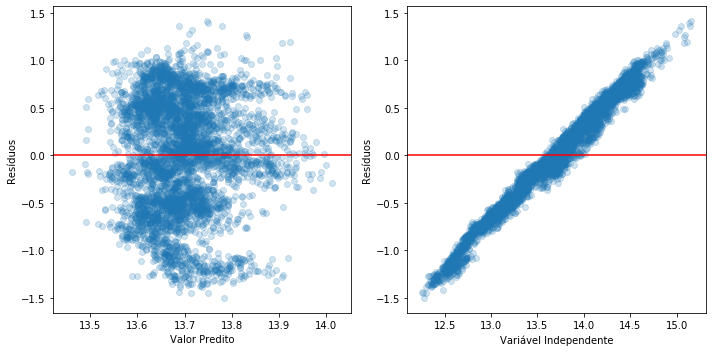

In [137]:
# Verificando a suposição de homocedasticidade na escala log:

fig = plt.figure(figsize = (10,5))

plt.subplot(121)
plt.scatter(logresults.predict(logxc), logresults.resid, alpha=0.2);
plt.axhline(y = 0, color = 'r', linestyle = '-');
plt.ylabel('Resíduos')
plt.xlabel('Valor Predito')

plt.subplot(122)
plt.scatter(logy, logresults.resid, alpha=0.2); # o valor da variável aleatórias está correto ?
plt.axhline(y = 0, color = 'r', linestyle = '-');
plt.ylabel('Resíduos')
plt.xlabel('Variável Independente')

plt.tight_layout()
plt.show()

### Modelo 2: Random Forest Regression

Iniciou-se modelo 2 retirando-se do DataFrame as variáveis que não fossem ser utilizadas como features, o que foi feito com o uso do comando ".drop()". Portanto, além da variável target, a serie "date" foi retirada, uma vez que seu tipo (datetime) não é adequado para o modelo. 

In [138]:
columns = df.columns.drop(['weeklysales', 'date'])
columns

Index(['store', 'holiday', 'temperature', 'fuel', 'cpi', 'unemployment',
       'year', 'month'],
      dtype='object')

Então dividiu-se o dataset em treinamento e teste novamente, desta vez armazenando os valores em quatro variáveis a serem usadas para a criação e validação do modelo. Para realizar essa divisão, utilizou-se o comando train_test_split, que tomou como parâmetros as features, o target e a porcentagem desejada para teste (25 % do dataset).

In [139]:
X_train, X_test, y_train, y_test = train_test_split(df[columns],df['weeklysales'], test_size=0.25)

Na célula seguinte foi definido o modelo que será utilizado nas predições das execuções seguintes. 

In [140]:
tree_rf = RandomForestRegressor()

Assim foi introduzido na biblioteca do modelo escolhido os dados de treinamento, anteriormente definidos, para que assim a biblioteca possa entender e trabalhar com os dados como random forest regression.

E, em seguida, com base no conhecimento do modelo sobre os dados de treinamento, utilizou-se o método de predição nos valores do target separados para teste, para que fosse possível analisar a performance do modelo. 

In [141]:
model_rf = tree_rf.fit(X_train, y_train)

resultado_rf = model_rf.predict(X_test)

Com as predições definidas calculou-se a média dos erros quadráticos sob as features que foram preditas em relação aos valores corretos, presentes no dataset. (Tal média do erro foi computada em dollares)

In [142]:
mean_squared_error(y_test, resultado_rf)

22978839766.649857

Posteriormente foi computada a porcentagem de acertos do modelo em relação aos testes, como pode ser visto a seguir. Percebe-se, então, que foi um valor razoável para a modelagem, uma vez que se aproxima de 1 (100%), mas que poderia ser melhorado. 

In [143]:
model_rf.score(X_test,y_test)

0.9288893749908398

Para melhorar os resultados do modelo Random Forest implementou-se hiperparâmetros ao longo dos códigos a seguir. 

Começou-se com a definição de um dicionário de parâmetros que tem como intuito definir de forma mais igualitária os parâmetros ao longo das árvores de decisão. Assim foi definido um valor mínimo de amostras a ser testado no nível folha da árvore, o quanto de amostra deve ir para cada árvore e quantas árvores seriam criadas. Desse modo nenhum árvore fica sobrecarregada e as features são bem distribuidas.

In [144]:
parametros = {'min_samples_leaf':[1,10],'min_samples_split':[2,10],'n_estimators':[100,250,500,750]} # parâmetros que queremos ajustar para melhorar

# valores mínimos de amostras para serem testadas na folha da árvore // valores mínimos de amostras para fazer a divisão do módulo interno, ajuda em deixar o modelo mais fluido. // árvores de decisão

Com os parâmetros definidos utilizou-se a função GridSearchCV que tem como função realizar um mutirão de testes exaustivamente, testando e retornando , a partir dos parâmetros sugeridos, os melhores dentre os testados para serem utilizados na implementação do modelo para a base de dados.

In [145]:
rf = RandomForestRegressor() # qual regressão vou usar 
grid = GridSearchCV(rf, parametros)

Assim utilizou-se a função anteriormente descrita na base de treinamento, como pode ser visto no código abaixo, e obteve-se os melhores parâmetros.

In [ ]:
grid.fit(X_train, y_train)

In [ ]:
grid.best_params_

Com os melhores parâmetros definidos e com o modelo entendendo quem são, buscou-se os melhores estimadores (variável rf_best) a fim de melhorar a predição que o modelo poderia retornar para a base de dados (resultado final - rf_best.predict(X_test))

In [ ]:
rf_best = grid.best_estimator_
resultado_final = rf_best.predict(X_test)
resultado_treinamento = rf_best.predict(X_train)

Com o modelo melhorado e desenvolvido, obteve-se a média dos erros quadráticos para as melhores predições, sendo percetível uma melhora, uma vez que o erro diminui.

In [ ]:
mean_squared_error(y_test, resultado_final)

Assim, também buscou-se o score para o modelo final e chegou-se a uma porcentagem de acerto do modelo melhor do que a anterior, o que evidencia um avanço na analise. 

In [ ]:
rf_best.score(X_test,y_test)

Por fim, na célula abaixo, obteve-se os valores preditos para a base de teste da variável target pelo modelo final de Random Forest Regression.

In [ ]:
rf_best.predict(X_test)

## - Processo e Estatísticas de Validação -

A fim de validar os modelos de predição, considerou-se importante a análise da qualidade de ajuste entre os dados de teste e a previsão feita pelos modelos, viabilizada pela utilização da medida $R^2$. Somado à tal análise, também foi realizada uma observação no tocante ao erro, utilizando a medida RMSE (Raiz do erro quadrático médio). 

A medida  $R^2$ é calculada por meio da seguinte fórmula: $R^2= 1 - \frac {Variações inexplicáveis} {Variação Total}$. Sendo assim, tem-se que esse parâmetro tem seus valores contidos em um intervalo de 0 até 1, sendo valores maiores que 0,85, representantes de uma forte correlação entre as variáveis de teste e as previstas pelo modelo. 
Já a medida RMSE, é calculada por meio da seguinte fórmula: $\sqrt{\frac{\displaystyle\sum\cdot e^2}{n}}$,
sendo e, o erro, n a quantidade de valores contidas na base de testes. 

Portanto, quanto menor é o parâmetro RMSE, melhor é a validação do modelo.

Dessa forma, plotou-se abaixo a função que calcula o $R^2$ da previsão do modelo pelos dados experimentais:

In [ ]:
def r_squared(dados, modelo):
    numerador = 0
    denominador = 0
    for i in range(len(modelo)):
        numerador += (dados[i]-modelo[i])**2
        denominador += (dados[i]-np.mean(dados))**2
    return 1 - numerador/denominador

#### Validação do modelo 1: Regressão Linear Múltipla

Para a validação do modelo 1, plotou-se inicialmente a seguinte função que prevê, dados os features, um valor para weeklysales:

In [ ]:
beta0_1 = results.params[0]
beta1_1 = results.params[1]
beta2_1 = results.params[2]
beta3_1 = results.params[3]

def f_modelo1(feature1, feature2, feature3):
    return beta0_1 + beta1_1*feature1 + beta2_1*feature2 + beta3_1*feature3

treinamento_1 = df_treinamento.weeklysales
predicoes_1_t = f_modelo1(df_treinamento.cpi, df_treinamento.unemployment, df_treinamento.month)
teste_1 = df_teste.weeklysales
predicoes_1 = f_modelo1(df_teste.cpi, df_teste.unemployment, df_teste.month)

 Plotou-se abaixo um gráfico, o qual mostra a venda semanal das lojas contidas na base de testes, bem como a venda semanal média prevista pelo modelo:

In [ ]:
y_teste = df_teste.weeklysales
y_previsto = f_modelo1(df_teste.cpi, df_teste.unemployment, df_teste.month)
x = df_teste.date

plt.figure(figsize=(12,7))
plt.title('Previsão pelo modelo 1')
plt.scatter(x, y_teste, alpha='0.3', color='blue', label='Dados observados')
plt.scatter(x, y_previsto, alpha='0.3', color='red', label='Modelo previsto')
plt.xlabel('Data (ano-mês)')
plt.ylabel('Vendas semanais (US$)')
plt.legend()
plt.grid(True)
plt.show()

Após isso, calculou-se o RMSE (medida de erro), o qual resultou em um valor alto, corroborando com o que é visto no gráfico, uma vez que os valores em vermelho, previstos pelo modelo, distanciam-se significativamente dos azuis. 

Calculou-se o RMSE para o modelo 1 na célula abaixo:

In [ ]:
# RMSE no treinamento
soma = 0
for resid in results.resid:
    soma += resid**2
RMSE_modelo1_t = np.sqrt(soma/len(df_treinamento))
print(f'RMSE do modelo 1 (treinamento): {RMSE_modelo1_t:.5f}')

In [ ]:
# RMSE no teste
residuos_1 = teste_1 - predicoes_1 #lista de residuos
soma = 0
for resid in residuos_1:
    soma += resid**2
RMSE_modelo1 = np.sqrt(soma/len(df_teste))
print(f'RMSE do modelo 1 (teste): {RMSE_modelo1:.5f}')

A comparação dos valores observados acima, permite a conclusão de que não houve Overfitting, cenário em que o modelo apresenta um erro muito menor quando submetido aos dados de treinamento, já conhecidos por ele, do que quando submetido a dados novos, da base de teste, o que seria não seria positivo para a previsão.

Utilizando-se a função de $R^2$ descrita acima, obteve-se abaixo tal valor para o modelo 1:

In [ ]:
# r^2 entre o modelo previsto e os dados treinamento
r_sqr_1_t = r_squared(list(treinamento_1),list(predicoes_1_t))
print(f'r^2 do modelo 1 (treinamento): {r_sqr_1_t:.5f}')

In [ ]:
# r^2 entre o modelo previsto e os dados teste
r_sqr_1 = r_squared(list(teste_1),list(predicoes_1))
print(f'r^2 do modelo 1 (teste): {r_sqr_1:.5f}')

Em relação ao parâmetro $R^2$, atestou-se também um valor baixo, o que indica uma qualidade de ajuste ruim do modelo. Apesar desses resultados comprovarem que o modelo 1 é bastante falho, pôde-se compreender o porquê dessa discrepância. Isso acontece, pois esse mesmo modelo não foi treinado para cada loja, mas sim considerando as features de todas as lojas em conjunto e, portanto, retorna um valor target médio. 

#### Validação do modelo 1 com escala logarítmica

Sendo assim, tendo em vista os resultados obtidos anteriormente, a fim de diminuir tal erro, validou-se também o modelo que tranformou todas as features e o target em escala logarítmica, construído anteriormente.

Função que prevê, dados os features, um valor para weeklysales

In [ ]:
beta0_1_log = logresults.params[0]
beta1_1_log = logresults.params[1]
beta2_1_log = logresults.params[2]
beta3_1_log = logresults.params[3]
beta4_1_log = logresults.params[4]

def f_modelo1_log(feature1, feature2, feature3, feature4): # função que prevê, dados os features, um valor previsto para weeklysales
    return beta0_1_log + beta1_1_log*feature1 + beta2_1_log*feature2 + beta3_1_log*feature3 + beta4_1_log*feature4

treinamento_1_log = df_treinamento_log.weeklysales
predicoes_1_log_t = f_modelo1_log(df_treinamento_log.temperature, df_treinamento_log.cpi, df_treinamento_log.unemployment, df_treinamento_log.month)
teste_1_log = df_teste_log.weeklysales
predicoes_1_log = f_modelo1_log(df_teste_log.temperature, df_teste_log.cpi, df_teste_log.unemployment, df_teste_log.month)

 Plota-se um gráfico, o qual mostra a venda semanal das semanas e lojas  contidas na base de testes e a venda semanal média prevista pelo modelo

In [ ]:
y_teste_log = df_teste_log.weeklysales
y_previsto_log = f_modelo1_log(df_teste_log.temperature, df_teste_log.cpi, df_teste_log.unemployment, df_teste_log.month)
x_log = df_teste_log.date

plt.figure(figsize=(12,7))
plt.title('Previsão pelo modelo 1 com escala logarítmica')
plt.scatter(x_log, y_teste_log, alpha='0.3', color='blue', label='Dados observados')
plt.scatter(x_log, y_previsto_log, alpha='0.3', color='red', label='Modelo previsto')
plt.xlabel('Data (ano-mês)')
plt.ylabel('Vendas semanais (log(US$))')
plt.legend()
plt.grid(True)
plt.show()

Calculou-se o RMSE para esse modelo:

In [ ]:
# RMSE (log) no treinamento
soma = 0
for resid in logresults.resid:
    soma += resid**2
RMSE_modelo1_log_t = np.sqrt(soma/len(df_treinamento_log))
print(f'RMSE do modelo 1 com escala logarítmica (treinamento): {RMSE_modelo1_log_t:.5f}')

In [ ]:
# RMSE (log) no teste
residuos_1_log = teste_1_log - predicoes_1_log #lista de residuos
soma = 0
for resid in residuos_1_log:
    soma += resid**2
RMSE_modelo1_log = np.sqrt(soma/len(df_teste_log))
print(f'RMSE do modelo 1 com escala logarítmica (teste): {RMSE_modelo1_log:.5f}')

A comparação dos valores observados acima, asim como na validação anterior, permite a conclusão de que não houve Overfitting.

Utilizando a função de $R^2$ acima descrita, obteve-se tal valor para o modelo 1 em escala log

In [ ]:
# r^2 entre o modelo previsto e os dados treinamento
r_sqr_1_log_t = r_squared(list(treinamento_1_log),list(predicoes_1_log_t))
print(f'r^2 do modelo 1 com escala logarítmica: {r_sqr_1_log_t:.5f}')

In [ ]:
# r^2 entre o modelo previsto e os dados teste
r_sqr_1_log = r_squared(list(teste_1_log),list(predicoes_1_log))
print(f'r^2 do modelo 1 com escala logarítmica: {r_sqr_1_log:.5f}')

Percebe-se, assim, que o valor de RMSE obtido foi bastante inferior ao anterior, porém o valor do parâmetro $R^2$, o qual já era baixo, decresceu ainda mais.

Dessa forma, pode-se atestar que o modelo 1 não obteve resultados de validação satisfatórios.


##### Validação do modelo 2: Random Forest Regression

 Assim como feito para os modelos anteriores, plotou-se um gráfico, o qual mostra a venda semanal para as semanas e lojas contidas na base de testes e a venda semanal média prevista pelo modelo:

In [ ]:
plt.figure(figsize=(12,7))
plt.title('Previsão pelo modelo 2')
plt.scatter(X_test.store, y_test, alpha='0.3', color='blue', label='Dados observados')
plt.scatter(X_test.store, resultado_final, alpha='0.3', color='red', label='Modelo previsto')
plt.xlabel('Número da loja')
plt.ylabel('Vendas semanais(US$)')
plt.legend()
plt.grid(True);

Calcula-se o RMSE para o modelo 2

In [ ]:
# RMSE para treinamento
treinamento_2 = y_train
predicoes_2_t = resultado_treinamento
residuos_2_t = treinamento_2 - predicoes_2_t #lista de residuos
soma = 0
for resid in residuos_2_t:
    soma += resid**2
RMSE_modelo2_t = np.sqrt(soma/len(y_train))
print(f'RMSE do modelo 2 (treinamento): {RMSE_modelo2_t:.5f}')

In [ ]:
# RMSE para teste
teste_2 = y_test
predicoes_2 = resultado_final
residuos_2 = teste_2 - predicoes_2 #lista de residuos
soma = 0
for resid in residuos_2:
    soma += resid**2
RMSE_modelo2 = np.sqrt(soma/len(y_test))
print(f'RMSE do modelo 2 (teste): {RMSE_modelo2:.5f}')

A comparação dos valores observados acima, leva a uma suspeita de que pode ter havido Overfitting, uma vez que o erro (RMSE) obtido quando o modelo foi submetido aos dados que já conhecia foi menor do que quando submetido a informações novas, pertencentes à base de teste.

Calculou-se também o $R^2$ para o modelo 2

In [ ]:
# r^2 para treinamento
r_sqr_2_t = r_squared(list(treinamento_2),list(predicoes_2_t))
print(f'r^2 do modelo 2 (treinamento): {r_sqr_2_t:.5f}')

In [ ]:
# r^2 para teste
r_sqr_2 = r_squared(list(teste_2),list(predicoes_2))
print(f'r^2 do modelo 2 (teste): {r_sqr_2:.5f}')

Deste modo, tendo em posse a análise dos parâmetros e do gráfico, pode-se perceber que esse modelo serve bem para prever a variável target, uma vez que tem-se um $R^2$ bastante alto, próximo de 1, um RMSE razoável e analisando-se o gráfico de dispersão, percebe-se uma boa proximidade entre o modelo previsto e os dados observados. No entanto, poderia ser aprimorado, a partir do uso de técnicas mais sofisticadas, a fim de apresentar um erro menor em suas previsões.

Por fim, plotou-se abaixo uma tabela que relaciona todos os valores de RMSE e $R^2$ obtidos ao longo da validação, obtendo-se a organização dos dados apresentada abaixo, a qual facilita a compreensão das relações descritas anteriormente.

In [ ]:
RMSEs = pd.Series([RMSE_modelo1_t, RMSE_modelo1, RMSE_modelo1_log_t, RMSE_modelo1_log, RMSE_modelo2_t, RMSE_modelo2])
r_sqrs = pd.Series([r_sqr_1_t, r_sqr_1, r_sqr_1_log_t, r_sqr_1_log, r_sqr_2_t, r_sqr_2])
indexes = pd.Series(['Modelo 1 - treinamento', 'Modelo 1 - teste', 'Modelo 1 (log) - treinamento', 'Modelo 1 (log) - teste', 'Modelo 2 - treinamento', 'Modelo 2 - teste'])
compare = pd.DataFrame()
compare['Modelos'] = indexes
compare['RMSE'] = RMSEs
compare['R^2'] = r_sqrs
compare

## - Conclusão -


Dentro de um contexto no qual a competição faz-se sempre presente, as previsões de demandas tornam-se essenciais à gestão das mais diversas organizações e, em especial no setor varejista, o qual passa, diariamente, por inúmeras transações. Tais previsões, quando adequadas, contribuem na tomada de decisões estratégicas e ajudam a reduzir desperdícios, sendo fundamentais para que a logística, estoque e compras não sejam fatores problemáticos, situação em que podem gerar prejuízo, mas sim fatores de geração de lucro (BONOTTO, 2015).

Nesse contexto, as ferramentas de Machine Learning são de grande apoio quando se tem um histórico de dados já registrado a disposição e objetiva-se prever valores futuros para uma variável de interesse buscando maior eficiência. Tendo-se isso em vista, é fundamental que o encarregado pelo manejo da base de dados use e busque conhecimentos cada vez mais refinados a fim de aperfeiçoar a análise e previsão.

Dessa forma, de acordo com as análises desenvolvidas ao longo deste relatório e com os modelos construídos, percebe-se que o modelo 1 não obteve resultados tão satisfatórios, uma vez que apresentou valores altos de erro e baixos de ajuste. Sendo assim, os melhores resultados foram obtidos com o uso do modelo de Random Forest Regression, o qual apresentou um $R^2$ maior que 0,85 e um RMSE menor que o obtido pelo modelo de regressão linear múltipla. 

Percebe-se então, que o modelo construído é capaz de auxiliar a empresa a ter um maior entendimento acerca das vendas semanais, possibilitando uma gestão mais eficiente da logística, estoque e compras. Assim, pode-se contribuir para a redução dos desperdícios, prevenção de prejuízos e maximização de lucros.


## - Referências Bibliográficas -

* https://www.lume.ufrgs.br/bitstream/handle/10183/147496/000999425.pdf?sequence=1

* http://prcrepository.org:8080/xmlui/bitstream/handle/20.500.12475/174/FA-19_Articulo%20Final_Jose%20Santaella.pdf?sequence=1

* https://www.cse.scu.edu/~mwang2/projects/ML_KaggleM5Forecasting_20s.pdf

* https://medium.com/datadriveninvestor/walmart-sales-data-analysis-sales-prediction-using-multiple-linear-regression-in-r-programming-adb14afd56fb

* https://medium.com/datadriveninvestor/random-forest-regression-9871bc9a25eb

* https://ensinandomaquinasblog.wordpress.com/2017/12/15/modelos-preditivos-de-notas-de-redacao-do-enem-2015/

* https://minerandodados.com.br/prevendo-dados-com-janelas-deslizantes-usando-python/

* https://medium.com/datadriveninvestor/k-fold-cross-validation-6b8518070833

* https://paulovasconcellos.com.br/como-saber-se-seu-modelo-de-machine-learning-est%C3%A1-funcionando-mesmo-a5892f6468b

* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

* https://minerandodados.com.br/prevendo-a-demanda-de-alugueis-de-bicicletas-com-machine-learning/

* https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html 

* https://medium.com/swlh/random-forest-and-its-implementation-71824ced454f 

* https://machinelearningmastery.com/overfitting-and-underfitting-with-machine-learning-algorithms/

* https://d1wqtxts1xzle7.cloudfront.net/41933645/FORECAST_OF_SALES_OF_WALMART_STORE_USING_BIG_DATA_APPLICATIONS.pdf?1454491981=&response-content-disposition=inline%3B+filename%3DFORECAST_OF_SALES_OF_WALMART_STORE_USING.pdf&Expires=1606270607&Signature=LrbwjlrF45qXyjNLe6q9q-Z-UiL3k6imM23FJP69XDQ~w9-s7smKHsLNuueAEXddGv3~suSMjac7Fv9McD-ZZ0MvR5nzF8eU-xN2EpgJXMvUP4OKc1kuwwHLlK-GN5wzKoFgRS7udo7w1~XWHeDV0EGLs1N-gnv3y-yMr8pI-Kjx34WnCg4b6Jzm2PhU53VS0zo7ZUx5NBK6VXVMd3EMO0Iq~7BH8MA2aZOJ05qVrQHERtEe3c7g1YWQ~-wZ8gZpNiUoqwQqQYQ6eJzo8baWHA42CuD2QrW6PVIRIfXQG9dbkWRXXhedn6h15d9yCfanvDNSGfrAa5MTQxkzniQyOw__&Key-Pair-Id=APKAJLOHF5GGSLRBV4ZA